## Set-up environment

In [1]:
!pip install -q rfdetr
!pip install -q roboflow
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

## Load dataset

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="m3uBqfpBS0TBjbn4OSco")
project = rf.workspace("asli-ece-turkmenoglu").project("logodet-3k-a6lrf")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to LogoDet-3K-1 in coco:: 100%|██████████| 4853/4853 [00:00<00:00, 9811.37it/s]


## Replacing categories of label to single category

In [3]:
import json
import os

def replace_all_category_ids(dataset_path):
    """
    Replace all category_id values with 0 and keep only the first category
    """
    
    splits = ['train', 'test', 'valid']
    
    for split in splits:
        annotation_file = os.path.join(dataset_path, split, '_annotations.coco.json')
        
        if not os.path.exists(annotation_file):
            print(f"Warning: {annotation_file} not found, skipping...")
            continue
            
        print(f"Processing {split} split...")
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            data = json.load(f)
        
        # Replace all category_id with 0
        for annotation in data['annotations']:
            annotation['category_id'] = 0
        
        # Keep only the first category (should be ID 0)
        if data['categories']:
            first_category = data['categories'][0]
            data['categories'] = [first_category]
        
        # Save back
        with open(annotation_file, 'w') as f:
            json.dump(data, f, indent=2)
        
        print(f"  - Updated {len(data['annotations'])} annotations")
        print(f"  - All category_id → 0")
        print(f"  - Categories: {data['categories'][0]['name'] if data['categories'] else 'None'}")

# Usage
dataset_path = dataset.location  # Replace with your path
replace_all_category_ids(dataset_path)

Processing train split...
  - Updated 4631 annotations
  - All category_id → 0
  - Categories: Logo
Processing test split...
  - Updated 563 annotations
  - All category_id → 0
  - Categories: Logo
Processing valid split...
  - Updated 562 annotations
  - All category_id → 0
  - Categories: Logo


## Sample Annotated Images from Train Set

In [4]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json")

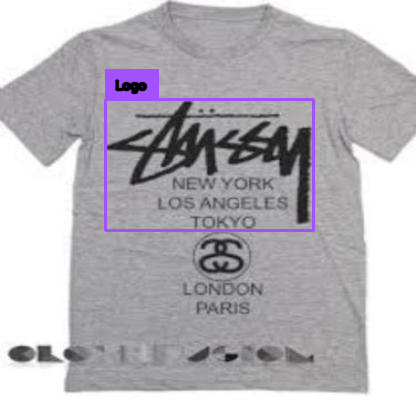

In [7]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)
annotation_image

# Training 

In [4]:
from rfdetr import RFDETRBase

model = RFDETRBase()

model.train(dataset_dir=dataset.location, epochs=5, batch_size=4, grad_accum_steps=4, lr=1e-4)

2025-05-29 02:29:12.056036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748485752.283365      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748485752.349165      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
rf-detr-base.pth: 100%|██████████| 355M/355M [00:03<00:00, 103MiB/s]  


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading pretrain weights
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=1, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=5, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, 

fatal: not a git repository (or any of the parent directories): .git


Epoch: [0]  [  0/242]  eta: 0:39:55  lr: 0.000100  class_error: 0.00  loss: 17.3126 (17.3126)  loss_ce: 0.8606 (0.8606)  loss_bbox: 2.2223 (2.2223)  loss_giou: 1.1438 (1.1438)  loss_ce_0: 0.7618 (0.7618)  loss_bbox_0: 2.2984 (2.2984)  loss_giou_0: 1.2732 (1.2732)  loss_ce_1: 0.8321 (0.8321)  loss_bbox_1: 2.1967 (2.1967)  loss_giou_1: 1.1957 (1.1957)  loss_ce_enc: 0.7828 (0.7828)  loss_bbox_enc: 2.4361 (2.4361)  loss_giou_enc: 1.3092 (1.3092)  loss_ce_unscaled: 0.8606 (0.8606)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.4445 (0.4445)  loss_giou_unscaled: 0.5719 (0.5719)  cardinality_error_unscaled: 1.0000 (1.0000)  loss_ce_0_unscaled: 0.7618 (0.7618)  loss_bbox_0_unscaled: 0.4597 (0.4597)  loss_giou_0_unscaled: 0.6366 (0.6366)  cardinality_error_0_unscaled: 1.0000 (1.0000)  loss_ce_1_unscaled: 0.8321 (0.8321)  loss_bbox_1_unscaled: 0.4393 (0.4393)  loss_giou_1_unscaled: 0.5978 (0.5978)  cardinality_error_1_unscaled: 1.0000 (1.0000)  loss_ce_enc_unscaled: 0.7828 (0.7828

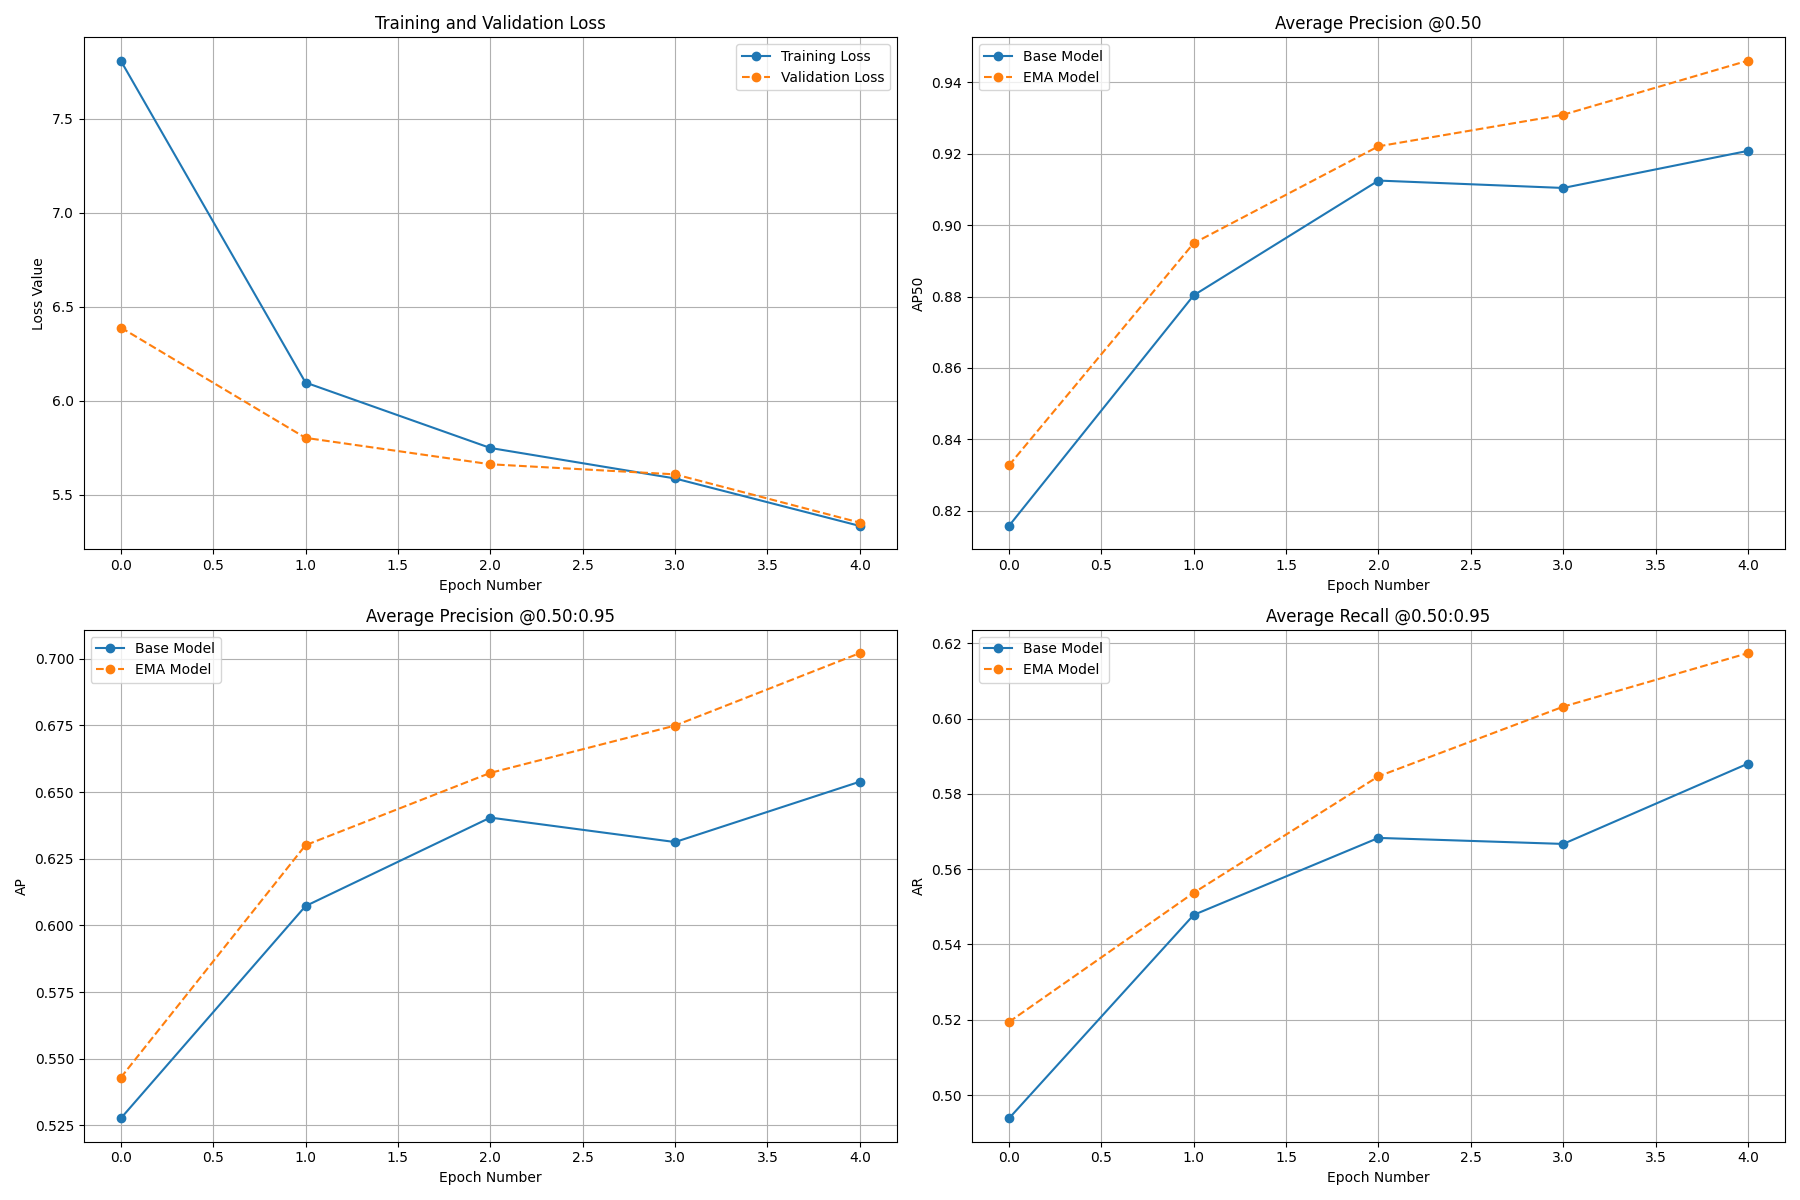

In [7]:
from PIL import Image

Image.open("output/metrics_plot.png")

## Run inference with fine-tuned model

In [7]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json")

## Comparing GroundTruths and Predictions

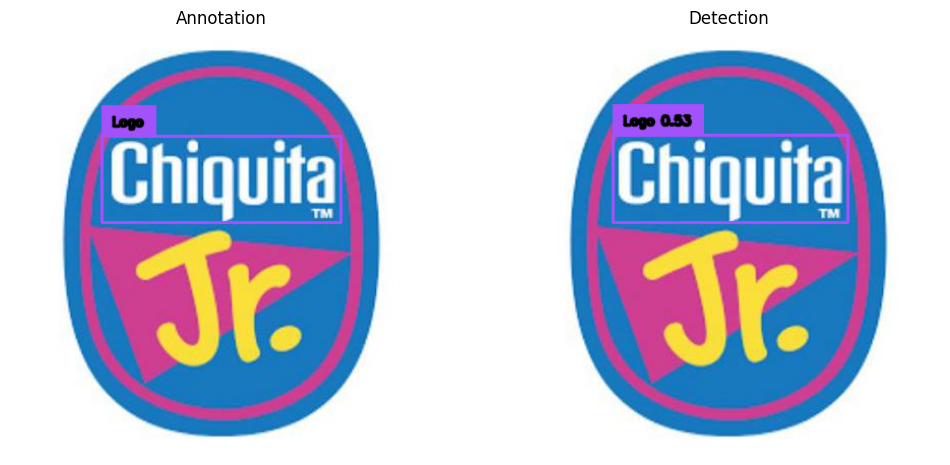

In [8]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

## Predictions from Test Set

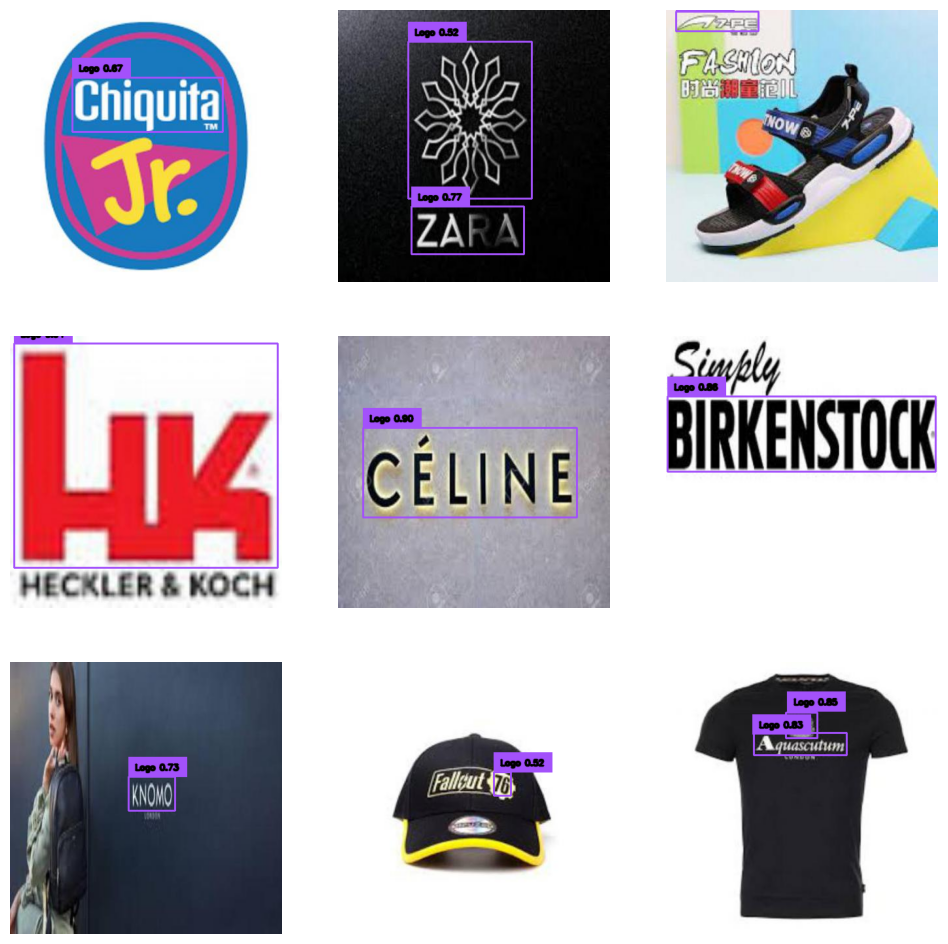

In [10]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

## Evaluate fine-tuned model

In [11]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 483/483 [00:21<00:00, 22.38it/s]


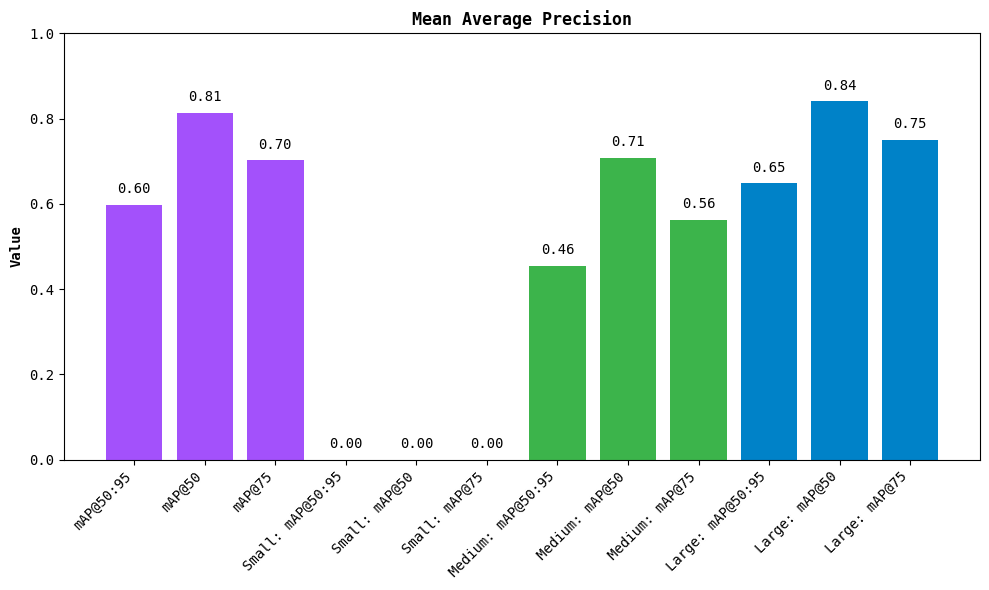

In [12]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

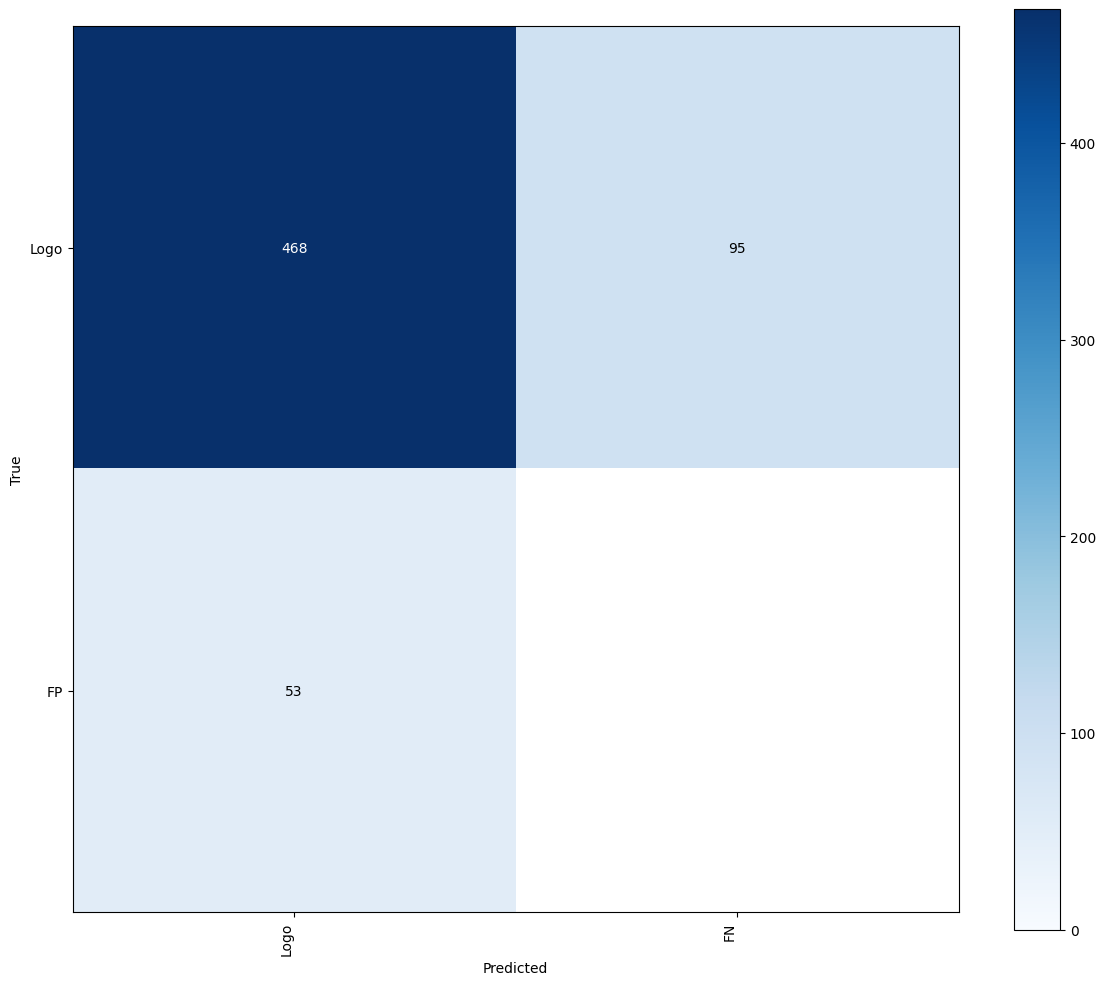

In [13]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot()

## Run inference for image

Loading pretrain weights


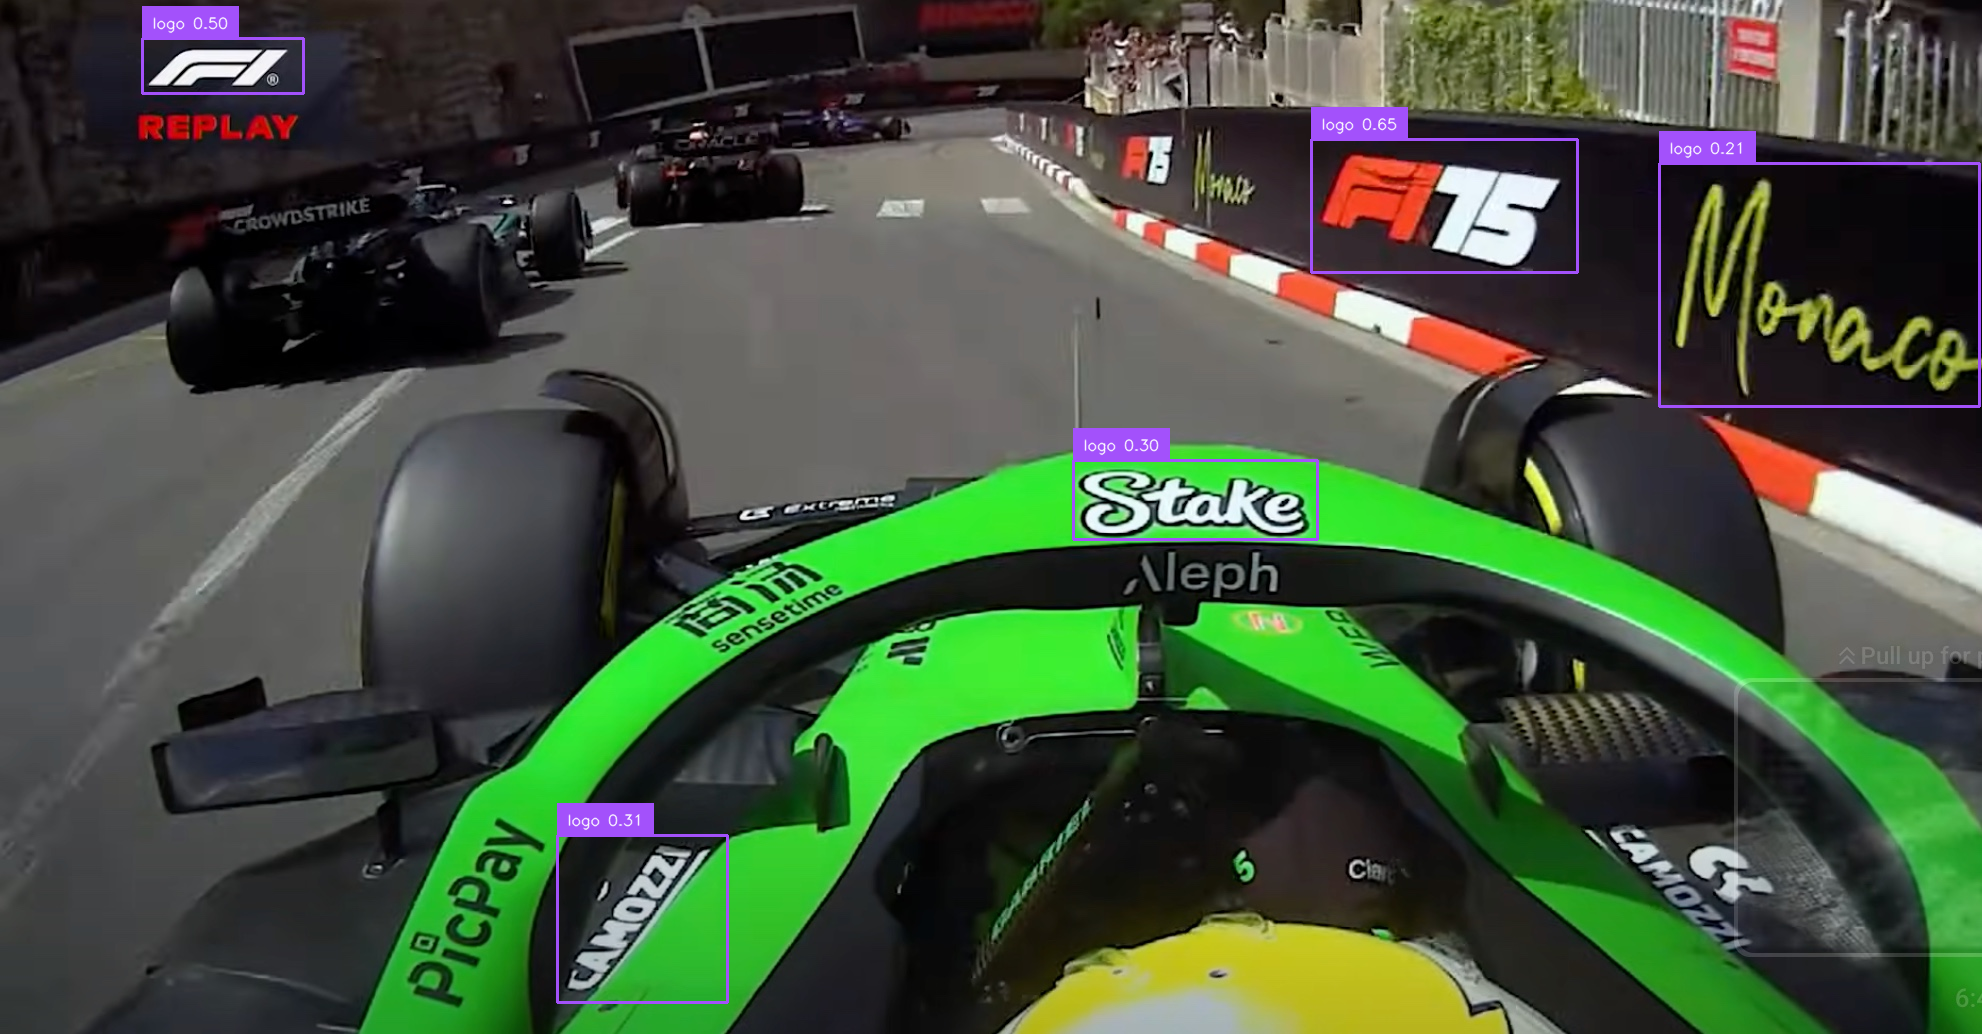

In [11]:
import io
import requests
import supervision as sv
from PIL import Image
from rfdetr import RFDETRBase

CLASSES = {
    0: "logo"}

model = RFDETRBase(pretrain_weights="/kaggle/input/modelsss/checkpoint_best_regular.pth")

image =  Image.open("/kaggle/input/testss/SCR-20250528-jurd-2.jpeg")
# image =  Image.open("/kaggle/input/testss/SCR-20250528-jvug-2.jpeg")

detections = model.predict(image, threshold=0.2)

labels = [
    f"{CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels)

annotated_image